# Flow Control and Measurement Design Challenge

Learn how to both control and measure flow rates using robust hydraulic designs. 
The [AguaClara code documentation](https://aguaclara.github.io/aguaclara/index.html) will be helpful as you search for useful functions. Remember to display calculated values with a reasonable number of significant digits. For our work 2 or 3 digits is normally appropriate. When designing hydraulic systems we rarely know any values to a greater precision than 1% error.

Total Points 30 
 * 26 for answers
 *  1 for completed draft 
 *  3 for style

In [0]:
!pip install aguaclara

In [0]:
from aguaclara.core.units import unit_registry as u
import aguaclara
from aguaclara.core import physchem as pc
from aguaclara.core import utility as ut
from aguaclara.core import pipes as pipes
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd

Researchers in the AguaClara laboratory collected the following head loss data through a 1/8" diameter tube that was 2 m long using water at 22 C. The data is in a comma separated data file named ['Head_loss_vs_Flow_dosing_tube_data.csv'](https://github.com/AguaClara/CEE4540_DC/blob/master/Head_loss_vs_Flow_dosing_tube_data.csv). Below we demonstrate how to use the pandas read_csv function to read the data file into a pandas data object.

In [0]:
dataurl = 'https://raw.githubusercontent.com/AguaClara/CEE3520/master/DC/data/Head_loss_vs_Flow_dosing_tube_data.csv'
head_loss_data = pd.read_csv(dataurl)  
print(head_loss_data)

    Head loss (m)  Flow rate (mL/min)
0           0.063               41.83
1           0.073               48.67
2           0.083                51.5
3           0.093               60.83
4           0.103                  67
5           0.113               73.33
6           0.123                  77
7           0.133               82.67
8           0.143                86.5
9           0.153               94.83
10          0.162                 102
11          0.172               106.8
12          0.182               112.8
13          0.192               115.7
14          0.202               122.7
15          0.212               128.2
16          0.221               133.8
17          0.231               135.5
18          0.241                 144
19          0.251                 148


### 1) (1 point)
Assign the head loss and the flow rate data to separate 1d NumPy arrays. Attach the correct units. NumPy.array can extract the data by simply passing it the text string of the column header. Here is example code to create the first array. `HL_data=np.array(head_loss_data['Head loss (m)'])*u.m`

*  1 point for creating separate array

### 2) (2 points)
Calculate and report the maximum and minimum Reynolds number for this data set.

* 2 points for correct min and max Re with reasonable significant digits

The Reynolds number varied from  290.0 to 1000.0 .


### 3) (3 Points)
You will now create a graph of head loss vs flow for the tube mentioned in the previous problems. This graph will have two sets of data: the real data contained within the csv file and a hydraulic model. The hydraulic model is what we would expect the head loss through the tube to be in an ideal world for any given flow. When calculating the hydraulic model head loss, assume that minor losses are negligible. Plot the data from the csv file as individual data points and the hydraulic model head loss as a continuous curve. Make the y-axis have units of cm and the x-axis have units of mL/s.

A few hints.

- To find the theoretical head loss, you will first need to create an array of different flow values. While you could use the values in the csv file, we would instead like you to create an array of 50 equally-spaced flow values. These values shall be between the minimum and maximum flows in the csv file.
- You can use the `np.linspace(start, stop, num)` function to create this set of equally-spaced flows. Linspace does not work with units; you can make the inputs dimensionless and then multiply the array by a scaling factor with units. `np.linspace(1, stop/start, 1) * start`
- The `pc.headloss_fric` function currently can not handle arrays as inputs. You can use a for loop. Create an array of zeroes with the correct units using the following code or something similar. `HL = (np.zeros(Graph_points)) * u.cm Then you can fill the array with the values in the for loop.
- When plotting, make sure to convert the flow and head loss data to the desired units that are defined in the axis labels.

Points
* 1 for creating correct arrays
* 2 for correct graph and labels

# Check to see if pc.headloss_fric can handle arrays as inputs!

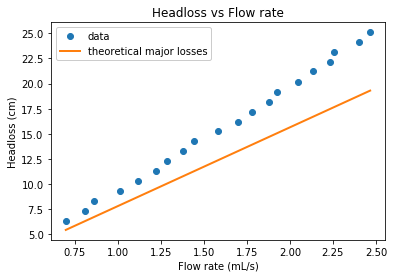

The theoretical model doesn't fit the data very well. We assumed that major losses dominated. It is also possible that some other parameter that we assumed or measured was incorrect. So let's try a more sophisticated approach where we fit minor losses to the data. Below we demonstrate the use of the [scipy curve_fit method](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html#scipy.optimize.curve_fit) to fit the minor loss coefficient given this data set.  


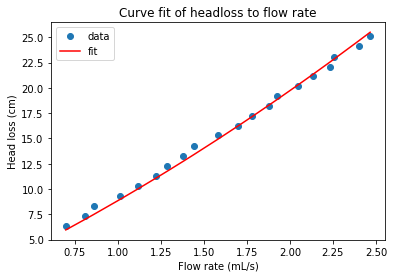

The minor loss coefficient was 13.0
The root mean square error for the model fit when adjusting the minor loss coefficient was  0.39 centimeter


In [0]:
from scipy.optimize import curve_fit

# Define a new function that calculates head loss given the flow rate
# and the parameter that we want to use curve fitting to estimate
# Define the other known values inside the function because we won't be passing those parameters to the function.

def HL_curvefit(FlowRate, KMinor):
    # The tubing is smooth AND pipe roughness isn't significant for laminar flow.
    PipeRough = 0*u.mm
    L_tube=2*u.m
    T_data=22*u.degC
    nu_data=pc.viscosity_kinematic(T_data)
    D_tube=1/8*u.inch
    # pass all of the parameters to the head loss function and then strip the units so
    # the curve fitting function can handle the data.
    HL_Fit = np.zeros(len(FlowRate))*u.m
    for i in range(0,len(FlowRate)):
      HL_Fit[i] = (pc.headloss(FlowRate[i], D_tube, L_tube, nu_data, PipeRough, KMinor)).to(u.m)
    return HL_Fit.to(u.m).magnitude

# The curve fit function will need bounds on the unknown parameters to find a real solution.
# The bounds for K minor are 0 and 20.

# The curve fit function returns a list that includes the optimal parameters and the covariance.

popt, pcov = curve_fit(HL_curvefit, Q_data.to(u.m**3/u.s), HL_data.to(u.m), bounds=[[2],[20]])

K_minor_fit = popt[0]
# Plot the raw data
plt.plot(Q_data.to(u.mL/u.s), HL_data.to(u.cm), 'o', label='data')

# Plot the curve fit equation.
plt.plot(Q_data.to(u.mL/u.s), ((HL_curvefit(Q_data, *popt))*u.m).to(u.cm), '-r', label='fit')
plt.xlabel('Flow rate (mL/s)')
plt.ylabel('Head loss (cm)')
plt.title('Curve fit of headloss to flow rate')
plt.legend()
plt.show()


#Calculate the root mean square error to estimate the goodness of fit of the model to the data
RMSE_Kminor = (np.sqrt(np.var(np.subtract((HL_curvefit(Q_data, *popt)),HL_data.magnitude)))*u.m).to(u.cm)
print('The minor loss coefficient was',ut.round_sf(K_minor_fit,2))
print('The root mean square error for the model fit when adjusting the minor loss coefficient was ',ut.round_sf(RMSE_Kminor,2))

### 4) (4 points)
Repeat the analysis above, but this time assume that the minor loss coefficient is zero and that diameter is the unknown parameter. The bounds specified in the line beginning with `popt, pcov` should be changed from the previous question (which had bounds from 0 to 20) to a reasonable range for the diameter of the tubing. We will use meter, kg, s as our units and remember that scipy doesn't use units. Thus set the  bounds to a range of diameters around the expected value.

Hint: You only need to change the name of the defined function (perhaps "`HL_curvefit2`"?) and adjust its inputs/values.

* 1 for correctly modifying the functions
*  2 for correct graph
*  1 for correct RMSE

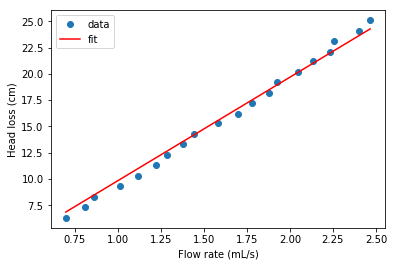

The tube diameter was 2.998 millimeter
The root mean square error for the model fit when adjusting the diameter was 1.5 centimeter


<Figure size 432x288 with 0 Axes>

### 5) (1 point)
Changes to which of the two parameters, minor loss coefficient or tube diameter, results in a better fit to the data?

* 1 point for correct answer

### 6) (4 Points)
Create a design for a [chemical dose controller using aguaclara](https://github.com/AguaClara/aguaclara/blob/master/aguaclara/design/cdc.py).  The plant flow rate is 60 L/s, the maximum concentration dose that they anticipate using is 40 mg/L as PACl, the stock concentration is 180 g/L, the maximum head loss for the CDC is 20 cm, the temperature is 20 degC and the minor loss coefficient for the dosing tubes is 3.

# add link to cdc documentation
Use the AguaClara cdc class to obtain the diameter, length, and number of dosing tubes that are required. Then take that design and use the physchem functions for flow in a pipe to calculate the maximum coagulant dose that it will deliver. This design and check is a powerful tool to ensure that you don't make mistakes because the design and the check are done using different code.

I've included the code necessary to get the length of the dosing tubes. Note that we are currently specifying the diameter of the dosing tubes to be 1/8". Remember that for laminar flow the surface roughness of the tubing isn't a significant parameter. Thus you can assume the tubing is smooth.

You can create a cdc with this code 

`import aguaclara.design.cdc as cdc
my_cdc=cdc.CDC(hl=20*u.cm,q=FlowPlant,coag_dose_conc_max=ConcDoseMax,temp=temp,tube_k=KMinor,coag_stock_conc_est=ConcStock)`

It is important to assign all of the inputs with the values that you want to use for your design. You can find out what inputs are used by entering command space while your cursor is in the parethesis.

`my_cdc=cdc.CDC(|)`

You can request a property of your cdc by typing a period after mycdc and then pressing command space to find out what properties are available. Here is the code to find the tube length.

`my_cdc.coag_tube_l`

* 1 for correct diameter of dosing tubes
* 1 point for correct number of dosing tubes
* 1 point for correct length of dosing tubes
* 1 point for correct maximum coagulant dose in the plant

The length of the dosing tube is 1.7 meter
The diameter of the dosing tube is 0.125 inch
The number of dosing tubes is 5.0
40.03 milligram / liter


### 7) (3 Points)
The LFOM (see the [lfom aguaclara code documentation](https://aguaclara.github.io/aguaclara/design/lfom.html)) for a 20 L/s plant was designed so the entrance tank water level changes by 20 cm as the flow goes from zero to 20 L/s. The safety factor for an lfom is the ratio of the amount of water that the pipe can carry (given its cross sectional area and the average vertical velocity of the water from free fall at the bottom of the LFOM) and the design flow rate. The safety factor was set to be 1.2 

The LFOM for this design is an 8 inch SDR 26 pipe.
Determine if the LFOM diameter will need to be increased to handle a flow of 30 L/s.


* 1 point for correct design for each flow rate
* 1 point for correct conclusion


The LFOM for a 20 liter / second AguaClara plant has a nominal diameter of 8 inch
The LFOM for a 30 liter / second AguaClara plant requires a nominal diameter of 8 inch
The diameter of the LFOM will increase from 8 inch to 8 inch


   
### 8) (3 Points)
Could you use the original LFOM diameter by increasing the depth of the entrance tank by 10 or 20 cm? The new LFOM depth range would then be either 30 or 40 cm.


* 1 point for correct design for each height
* 1 point for correct conclusion


The diameter of an LFOM that has a height of 30 cm is 10 inch
The diameter of an LFOM that has a height of 40 cm is 8 inch
The same diameter LFOM could be used if the height were increased to 40 cm.
